# Import librairies

In [1]:
import os

seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)

import sys
import random

sys.path.append("../utile")
sys.path.append("..")
from database import create_cnx, config_parse
import pandas as pd
from pandas.api.types import is_numeric_dtype
from data import DataSet

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

path = "../data"
plt.rcParams["figure.figsize"] = (15, 15)
import base64

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Concatenate,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras import Model, regularizers
import keras.backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import InputSpec
from model import Deep_Embedding_Model, DEC

from shapely.geometry import Polygon, LineString, Point
from shapely.ops import unary_union
import geopandas
from geopandas import GeoSeries

from difflib import get_close_matches

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2022-03-07 20:09:28.797212: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-03-07 20:09:32.381505: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-07 20:09:32.538271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 20:09:32.538421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-07 20:09:32.538483: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-07 20:09:32.676931: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-07 20:09:32.677102: I tensorflow/stream_exec

# Loading data and utile functions

## Loading data from database

In [3]:
# Get data from VDSA dataset
parser = config_parse()
cnx = create_cnx(parser)["cnx"]
curs = cnx.cursor()


sql_request = """
SELECT * 
FROM Land_Use lu

LEFT JOIN Source_Wise_Irrigated_Area swia
    ON swia.STNAME = lu.STNAME
    AND swia.DISTNAME = lu.DISTNAME
    AND swia.YEAR = lu.YEAR

LEFT JOIN Fertilizer_Consumption fc
    ON fc.STNAME = lu.STNAME
    AND fc.DISTNAME = lu.DISTNAME
    AND fc.YEAR = lu.YEAR

LEFT JOIN Fertilizer_Prices fp
    ON fp.STNAME = lu.STNAME
    AND fp.DISTNAME = lu.DISTNAME
    AND fp.YEAR = lu.YEAR

LEFT JOIN Annual_Monthly_Actual_Rainfall amar
    ON amar.STNAME = lu.STNAME
    AND amar.DISTNAME = lu.DISTNAME
    AND amar.YEAR = lu.YEAR

LEFT JOIN Population_Census pc
    ON pc.STNAME = lu.STNAME
    AND pc.DISTNAME = lu.DISTNAME
    AND pc.YEAR = lu.YEAR

LEFT JOIN Agriculture_Implements_Census aic
    ON aic.STNAME = lu.STNAME
    AND aic.DISTNAME = lu.DISTNAME
    AND aic.YEAR = lu.YEAR

LEFT JOIN Wage_Rate wr
    ON wr.STNAME = lu.STNAME
    AND wr.DISTNAME = lu.DISTNAME
    AND wr.YEAR = lu.YEAR

LEFT JOIN Operation_Holding oh
    ON oh.STNAME = lu.STNAME
    AND oh.DISTNAME = lu.DISTNAME
    AND oh.YEAR = lu.YEAR
    
LEFT JOIN Annal_Monthly_Normal_Rainfall amnr
    ON amnr.STNAME = lu.STNAME
    AND amnr.DISTNAME = lu.DISTNAME
    
LEFT JOIN Soil_Type st
    ON st.STNAME = lu.STNAME
    AND st.DISTNAME = lu.DISTNAME
    
LEFT JOIN Annual_Monthly_Normal_Potential_Evapotranspiration anpe
    ON anpe.STNAME = lu.STNAME
    AND anpe.DISTNAME = lu.DISTNAME

LEFT JOIN Annual_Moisture_Available ama
    ON ama.STNAME = lu.STNAME
    AND ama.DISTNAME = lu.DISTNAME
"""
curs.execute(sql_request)
names = [x[0] for x in curs.description]
rows = curs.fetchall()
df_vdsa = pd.DataFrame(rows, columns=names)

df_vdsa.drop("id", inplace=True, axis=1)
# df = df.loc[:,~df.columns.duplicated()]
df_vdsa.dropna(axis=0, how="all", inplace=True)
# df.drop(axis=1,labels='index', inplace=True)

In [4]:
# Delete duplicate columns
df_vdsa = df_vdsa.loc[:, ~df_vdsa.columns.duplicated()]

In [5]:
df_vdsa

,STCODE,STNAME,DIST,DISTNAME,YEAR,TOTGEOG,FOREST,BARREN,NONAGRI,CWASTE,...,AUG,SEPTEMBER,OCTOBER,NOV,DECEMBER,SOILTYPE,ANNRF,ANNDP,ANNUAL_PE,ANNMAI
0,1,andhra pradesh,44,srikakulam,1970,967.2,151,131.1,74.1,37.2,...,189,229,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436
1,1,andhra pradesh,44,srikakulam,1976,967.2,150.3,119,97.4,20.7,...,189,229,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436
2,1,andhra pradesh,44,srikakulam,1980,899.8,128.5,105.6,99,16.7,...,189,229,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436
3,1,andhra pradesh,44,srikakulam,1986,899.3,126.2,105,111.3,15.6,...,189,229,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436
4,1,andhra pradesh,44,srikakulam,1990,899.3,126.4,102.1,111.6,12.6,...,189,229,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14081,13,west bengal,818,midnapur,2002,1325.17,181.62,2.69,248.43,5.24,...,None,None,None,None,None,None,None,None,None,None
14082,13,west bengal,818,midnapur,2004,1325.17,172.84,5.69,249.09,5.43,...,None,None,None,None,None,None,None,None,None,None
14083,13,west bengal,818,midnapur,2005,1326,173,6,246,6,...,None,None,None,None,None,None,None,None,None,None
14084,13,west bengal,818,midnapur,2006,1325.175,172.834,2.188,254.371,6.622,...,None,None,None,None,None,None,None,None,None,None


## Handle link between vdsa and scor datasets

 Here is a trick; since we know after looking at vdsa dataset that there are many values not linked to SCOR (for both States and District), 
we decide to use columns longitude and latitude of vdsa and link it to the shapefile from this source https://gadm.org/download_country.html which is easier to link with SCOR dataset (it is the dataset we used to link vegetation images dataset

In [6]:
# Import shapefile and create column with state and district name
file = geopandas.read_file("../material/files/gadm36_IND.gpkg")
file["total_name"] = file.apply(
    lambda x: f"{x['NAME_2']}, {x['NAME_1']}, India", axis=1
)

In [7]:
# Group by state/district
file_group = file.groupby(by=["NAME_1", "NAME_2"])["geometry"].apply(
    lambda x: unary_union(x)
)

In [8]:
# Display values we don't have for longitude and latitude
df_vdsa[df_vdsa["LON"].isna() | df_vdsa["LAT"].isna()]

,STCODE,STNAME,DIST,DISTNAME,YEAR,TOTGEOG,FOREST,BARREN,NONAGRI,CWASTE,...,AUG,SEPTEMBER,OCTOBER,NOV,DECEMBER,SOILTYPE,ANNRF,ANNDP,ANNUAL_PE,ANNMAI
2294,1,andhra pradesh,50,s.p.s. nellore,2010,1977.39,438.34,197.25,322.49,126.05,...,None,None,None,None,None,None,None,None,None,None
2295,1,andhra pradesh,52,anantapur,1970,1913.5,193.5,192.8,146.1,144.7,...,None,None,None,None,None,None,None,None,None,None
2296,1,andhra pradesh,52,anantapur,1976,1913.5,193.8,193.1,147.3,113.8,...,None,None,None,None,None,None,None,None,None,None
2297,1,andhra pradesh,52,anantapur,1980,1913.5,195.3,189.6,158.2,84.9,...,None,None,None,None,None,None,None,None,None,None
2298,1,andhra pradesh,52,anantapur,1986,1913.5,196.8,189.6,158.2,86,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14081,13,west bengal,818,midnapur,2002,1325.17,181.62,2.69,248.43,5.24,...,None,None,None,None,None,None,None,None,None,None
14082,13,west bengal,818,midnapur,2004,1325.17,172.84,5.69,249.09,5.43,...,None,None,None,None,None,None,None,None,None,None
14083,13,west bengal,818,midnapur,2005,1326,173,6,246,6,...,None,None,None,None,None,None,None,None,None,None
14084,13,west bengal,818,midnapur,2006,1325.175,172.834,2.188,254.371,6.622,...,None,None,None,None,None,None,None,None,None,None


In [9]:
# Create State and District columns to link to SCOR dataset
def set_state_district(x, granularity):
    err = 0
    if x["LON"] and x["LAT"]:

        if granularity == "State":
            try:

                output = file_group[
                    file_group.contains(Point(float(x["LON"]), float(x["LAT"])))
                ].index.tolist()[0][0]
                if output:
                    return output.lower()
            except:
                err = 1

        if granularity == "District":
            try:
                output = file_group[
                    file_group.contains(Point(float(x["LON"]), float(x["LAT"])))
                ].index.tolist()[0][1]
                if output:
                    return output.lower()
            except:
                err = 1

    elif not x["LON"] or not x["LAT"] or err == 1:
        if granularity == "State":
            return x["STNAME"]
        if granularity == "District":
            return x["DISTNAME"]


df_vdsa["State"] = df_vdsa.apply(lambda x: set_state_district(x, "State"), axis=1)
df_vdsa["District"] = df_vdsa.apply(lambda x: set_state_district(x, "District"), axis=1)

In [10]:
# Handle missing values
df_vdsa["District"] = df_vdsa["District"].fillna(df_vdsa["DISTNAME"])
df_vdsa["State"] = df_vdsa["State"].fillna(df_vdsa["STNAME"])

# Link vdsa and SCOR dataset

In [11]:
# Get all different states/districts of vdsa
states = df_vdsa["State"].unique().tolist()
districts = df_vdsa["District"].unique().tolist()
states_district = df_vdsa[["State", "District"]].apply(
    lambda x: x["State"] + "/" + x["District"], axis=1
)

In [12]:
# Get distinct states/districts from SCOR to link it to VDSA
sql_request = """SELECT DISTINCT State, District from data_SCOR"""
curs.execute(sql_request)
names = [x[0] for x in curs.description]
rows = curs.fetchall()
df_scor = pd.DataFrame(rows, columns=names)

In [13]:
# Get all different states/districts of SCOR
scor_states = df_scor["State"].unique()
scor_districts = df_scor["District"].unique()
scor_states_district = df_scor[["State", "District"]].apply(
    lambda x: x["State"] + "/" + x["District"], axis=1
)

In [14]:
rate = round(
    len(set(scor_states_district) - set(states_district))
    / len(set(scor_states_district))
    * 100,
    2,
)
print(
    f"The ratio of values which are in SCOR dataset and not in vdsa dataset is around {rate} %"
)

The ratio of values which are in SCOR dataset and not in vdsa dataset is around 56.04 %


In [15]:
# Fuzzy match between VDSA and SCOR datasets on states/districts
list_to_change = {}

for elem in list(set(states_district) - set(scor_states_district)):
    # print(elem)
    # district = elem.split("/")[1]
    # print(district)
    if not get_close_matches(elem, list(set(states_district))):
        # Small trick, check if the first word in district name could find a match with VDSA dataset
        try:
            # If we can't match both districts; verify if we can't match first word with SCOR districts
            if not get_close_matches(
                elem.split("/")[0] + elem.split("/")[1].split(" ")[0],
                list(set(districts)),
            ):
                print(elem, "  -> No match found")
                print()
            else:
                # pass
                list_to_change[
                    get_close_matches(
                        elem.split("/")[0] + elem.split("/")[1].split(" ")[0],
                        list(set(districts)),
                    )[0]
                ] = elem
                # print(get_close_matches(elem.split("/")[0]+elem.split("/")[1].split(" ")[0], list(set(districts)))[0])
                print()
        except:
            print(elem, "  -> No match found")
            print()
    else:
        # pass
        list_to_change[get_close_matches(elem, list(set(states_district)))[0]] = elem
        # print(elem,"///", get_close_matches(elem, list(set(states_district)))[0])
        # print()

In [16]:
# Apply changes of name with closest matches
def change_names(x):
    # print(x)
    elem = x["State"] + "/" + x["District"]
    if elem in list_to_change.keys():
        x["State"] = list_to_change[elem].split("/")[0]
        x["District"] = list_to_change[elem].split("/")[1]
        return x
    else:
        return x


df_vdsa[["State", "District"]] = df_vdsa[["State", "District"]].apply(
    change_names, axis=1
)

In [17]:
df_vdsa.drop(columns=["STCODE", "STNAME", "DIST", "DISTNAME"], inplace=True)

In [18]:
df_vdsa

,YEAR,TOTGEOG,FOREST,BARREN,NONAGRI,CWASTE,PPASTUR,OTFALOW,CUFALOW,CANALS,...,OCTOBER,NOV,DECEMBER,SOILTYPE,ANNRF,ANNDP,ANNUAL_PE,ANNMAI,State,District
0,1970,967.2,151,131.1,74.1,37.2,19.3,22.7,21.7,69,...,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436,andhra pradesh,srikakulam
1,1976,967.2,150.3,119,97.4,20.7,14.8,18,45.8,75.2,...,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436,andhra pradesh,srikakulam
2,1980,899.8,128.5,105.6,99,16.7,5.7,13.8,41.5,86,...,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436,andhra pradesh,srikakulam
3,1986,899.3,126.2,105,111.3,15.6,5.4,15.6,33.9,98.7,...,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436,andhra pradesh,srikakulam
4,1990,899.3,126.4,102.1,111.6,12.6,4.9,11.8,27.6,118.1,...,192,83,10,orthids - 100%,1104,926,1560,0.5935897435897436,andhra pradesh,srikakulam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14081,2002,1325.17,181.62,2.69,248.43,5.24,1.18,7.98,19.23,None,...,None,None,None,None,None,None,None,None,west bengal,midnapur
14082,2004,1325.17,172.84,5.69,249.09,5.43,0.63,4.71,23.95,None,...,None,None,None,None,None,None,None,None,west bengal,midnapur
14083,2005,1326,173,6,246,6,2,6,23,None,...,None,None,None,None,None,None,None,None,west bengal,midnapur
14084,2006,1325.175,172.834,2.188,254.371,6.622,0.891,4.572,24.545,None,...,None,None,None,None,None,None,None,None,west bengal,midnapur


In [19]:
# Take the average through years for every features in VDSA
def f_group(x):
    try:
        return pd.to_numeric(x).mean()

    except:
        return x.mode()


df_vdsa_groupby = (
    df_vdsa.drop(columns=["YEAR"]).groupby(["State", "District"]).agg(f_group)
)
df_vdsa_groupby.reset_index(inplace=True)

# Loading data from database

In [20]:
# Get SCOR data for a given season
parser = config_parse()
cnx = create_cnx(parser)["cnx"]
curs = cnx.cursor()
season = "rabi"
sql_request = (
    f"""SELECT DISTINCT * from data_SCOR WHERE Season = "{season}" ORDER BY RAND() """
)
curs.execute(sql_request)
names = [x[0] for x in curs.description]
rows = curs.fetchall()
df = pd.DataFrame(rows, columns=names)

In [21]:
# Merge SCOR's and VDSA's datasets
df = pd.merge(
    df,
    df_vdsa_groupby,
    how="left",
    left_on=["State", "District"],
    right_on=["State", "District"],
)

In [22]:
# Get features we are interested in
numeric_features = [
    "Area_Sown_Ha",
    "Area_Insured_Ha",
    "SI_Per_Ha_Inr_Ha",
    "Sum_Insured_Inr",
    "Indemnity_Level",
    "TOTGEOG",
    "FOREST",
    "BARREN",
    "CWASTE",
    "PPASTUR",
    "OTFALOW",
    "CUFALOW",
    "CANALS",
    "TANKS",
    "TUBEWELL",
    "OTHWELL",
    "TOTWELL",
    "OTHSOUR",
    "N_TC",
    "P_TC",
    "K_TC",
    "NPK_TC",
    "N_TP",
    "P_TP",
    "K_TP",
    "ANNUAL",
    "POP_T",
    "POP_M",
    "POP_F",
    "POP_RU",
    "POP_RM",
    "POP_RF",
    "POP_UB",
    "POP_UM",
    "POP_UF",
    "DIESEL_PS",
    "ELECTRIC_PS",
    "POWER_T",
    "TRACTOR",
    "MALE_WAGE",
    "FEM_WAGE",
    "MARG_NO",
    "MARG_AR",
    "SMALL_NO",
    "SMALL_AR",
    "SEMIM_NO",
    "SEMIM_AR",
    "MEDIUM_NO",
    "MEDIUM_AR",
    "LARGE_NO",
    "LARGE_AR",
    "TOTAL_NO",
    "TOTAL_AR",
    "LAT",
    "LON",
    "ANNDP",
    "ANNRF",
    "ANNMAI",
]
textual_features = [
    "District",
    "Sub_District",
    "Crop",
    "Block",
    "State",
    "Cluster",
    # "SOILTYPE",
]
# Load custom class dataset
df = DataSet(
    numeric_features=numeric_features,
    textual_features=textual_features,
    data=df,
    columns=df.columns,
)
# df = pd.DataFrame(rows, columns=names)
df.drop("id", inplace=True, axis=1)
df.dropna(axis=0, how="all", inplace=True)
# df.drop(axis=1,labels='index', inplace=True)
print(len(df))

# "PPMRKT",
# "PSMRKT",
# "PTMRKT",
# "LROAD",
# "ANNPE",

/appli/notebooks/../utile/data.py:63: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.numeric_features = numeric_features
/appli/notebooks/../utile/data.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.textual_features = textual_features
/appli/notebooks/../utile/data.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.values_list_to_replace = values_list_to_replace


410997


# Preprocessing and encoding

## Pre-processing

In [23]:
# Keep only crop yields years with enough data
df.set_years_to_keep(drop=False)
# Subset dataframe to keep only numeric features, textual features, and crop yields years
df.subset_data()
# Preprocess numeric features
df.pre_process_numeric()
# Preprocess textual features

{'2007_Yield': 3458.5794816695716, '2008_Yield': 3417.847702131436, '2009_Yield': 3884.756365521781, '2010_Yield': 3835.378456503958, '2011_Yield': 3885.5401339173122, '2012_Yield': 3912.156551564112, '2013_Yield': 3590.0603680096465, '2014_Yield': 3451.4673340809077}


/appli/notebooks/../utile/data.py:101: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.years_crop_yields = [f"{year}_Yield" for year in years_to_keep]


In [24]:
df.preprocess_textual()
# df= DataSet(
#     numeric_features=numeric_features,
#     textual_features=textual_features,
#     data=rows,
#     columns=df.columns,
# )
# df.drop("index", inplace=True, axis=1)

/appli/notebooks/../utile/data.py:171: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  indx_non_null_other = reduce(


In [25]:
len(df)

410997

## Encoding

In [26]:
df.set_dict_shape()
# Encode OHE feature
df.encode_ohe()
# Encode textual feature
df.encode_textual()

/appli/notebooks/../utile/data.py:219: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.dict_shape = dict_shape
/appli/notebooks/../utile/data.py:256: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.vocab = vocab


In [27]:
dict_shape = df.dict_shape

# Regression Model

In [28]:
# Define model
from model import Deep_Embedding_Model

Dense_embedding_model = Deep_Embedding_Model(
    dict_shape=dict_shape,
    textual_features=textual_features,
    numeric_features=numeric_features,
    outputs_shape=len(df.years_crop_yields),
).model()

2022-03-07 20:18:49.976516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 20:18:50.061226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 20:18:50.061385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 38 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-07 20:18:50.062126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/b

In [29]:
# Train/ test split
inputs = df.df_train_test_split()
inputs_train = [
    inputs["textual"]["train"],
    inputs["numeric"]["train"],
    # input_ohe_dict_train,
]
inputs_test = [
    inputs["textual"]["test"],
    inputs["numeric"]["test"],
    # input_ohe_dict_train,
]

epochs = 200
history = Dense_embedding_model.fit(
    inputs_train,  #
    inputs["label"]["train"],
    epochs=epochs,
    batch_size=512,
    # validation_split = 0.3,
    validation_data=(inputs_test, inputs["label"]["test"]),
    verbose=1,
)

2022-03-07 20:19:08.405484: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-07 20:19:08.785748: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496005000 Hz


Epoch 1/200


2022-03-07 20:19:12.912915: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-07 20:19:42.178480: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-07 20:19:42.213889: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


562/562 [==============================] - 47s 25ms/step - loss: 8144102.5000 - mae: 1239.2697 - val_loss: 3207581.0000 - val_mae: 695.7827
Epoch 2/200
562/562 [==============================] - 14s 25ms/step - loss: 3419195.7500 - mae: 796.1449 - val_loss: 3120087.7500 - val_mae: 675.9160
Epoch 3/200
562/562 [==============================] - 14s 25ms/step - loss: 3185523.0000 - mae: 781.7426 - val_loss: 2779170.0000 - val_mae: 646.1719
Epoch 4/200
562/562 [==============================] - 14s 26ms/step - loss: 2818841.7500 - mae: 765.0363 - val_loss: 2318763.7500 - val_mae: 609.0933
Epoch 5/200
562/562 [==============================] - 15s 26ms/step - loss: 2534695.2500 - mae: 738.4337 - val_loss: 2216416.5000 - val_mae: 573.0782
Epoch 6/200
562/562 [==============================] - 14s 24ms/step - loss: 2498326.2500 - mae: 727.8984 - val_loss: 2120352.7500 - val_mae: 569.6804
Epoch 7/200
562/562 [==============================] - 14s 25ms/step - loss: 2397130.5000 - mae: 720.9506

In [31]:
list_embedding_clustering = {}
# Textual feature we want to keep for the clustering space
textual_features_to_keep = ["State", "District", "Sub_District", "Block"]
for feature in textual_features_to_keep:
    # Get trained embedding layer and apply it to the input
    list_embedding_clustering[feature] = Flatten()(
        Dense_embedding_model.get_layer(f"Embedding_{feature}")(
            Dense_embedding_model.input[0][feature]
        )
    )
# If there are several features, concatenate all embeddings
concatted_clustering = Concatenate(name="concatted_clustering")(
    list(list_embedding_clustering.values())
)

# Define the model for the projection of data onto clustering space
model_feature_representation = Model(
    inputs=[
        {key: Dense_embedding_model.input[0][key] for key in textual_features_to_keep}
    ],
    outputs=concatted_clustering,
    name="model_feature_representation",
)

# CLustering model only with embedding of states district etc.

The parts 7-8-9 are not needed to be run if you want to run cluster directly on the data for clustering, it is mostly to display results

In [36]:
# Apply embedding projection model to the input
# X_train_embedded = model_feature_representation.predict([inputs["textual"]["train"]])
inputs_total = {}
for key in textual_features_to_keep:
    inputs_total[key] = np.array(
        [*inputs["textual"]["train"][key], *inputs["textual"]["test"][key]]
    )
X_train_embedded = model_feature_representation.predict([inputs_total])

# Take only unique values for the clustering (there are several times the same location in the dataset so we just keep one point for each location)
uniques = np.unique(X_train_embedded, axis=0)

In [37]:
nb_clusters = 6
model_kmeans = KMeans(nb_clusters).fit(uniques)
y_pred = model_kmeans.predict(uniques)

In [38]:
# Get Davies Bouldin index for each number of cluster
davies_bouldin_scores = []
for k in range(2, 20):
    model_kmeans = KMeans(k).fit(uniques)
    davies_bouldin_scores.append(
        davies_bouldin_score(uniques, model_kmeans.predict(uniques))
    )

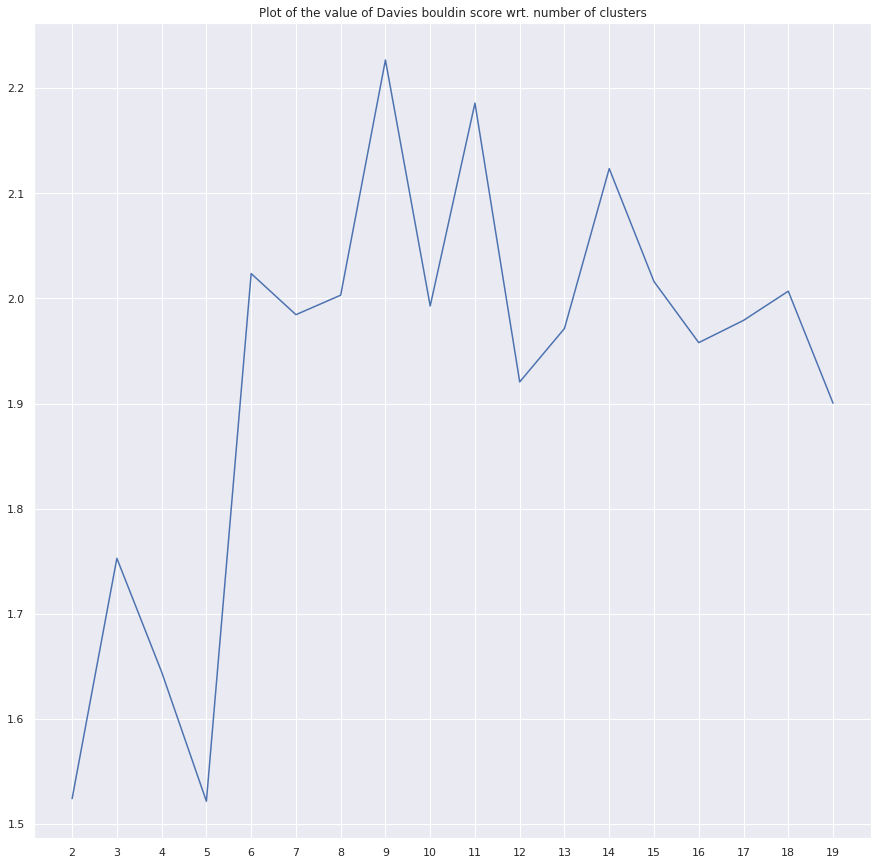

In [39]:
# Display the value of the index wrt. the number of clusters
sns.set_theme()
plt.plot(np.arange(2, 20), davies_bouldin_scores)
plt.title("Plot of the value of Davies bouldin score wrt. number of clusters")
ticks = plt.xticks(np.arange(2, 20))

# Deep Embedding Clustering(DEC )

In [40]:
# Define DEC model
DEC_model = DEC(dims=[uniques.shape[1]])
DEC_model.encoder_models()

TypeError: in user code:


    TypeError: tf__build() got an unexpected keyword argument 'training'


In [ ]:
# Train AE
history = DEC_model.model_AE.fit(
    uniques,
    uniques,
    epochs=150,
    batch_size=128,
    validation_split=0.3,
)

In [ ]:
# Visualize training
sns.set_theme()
plt.plot(history.history["mae"], label="MAE")
plt.ylabel("Value of mae")
plt.xlabel("Number of epochs")
# ticks = plt.xticks(np.arange(1, epochs+1))
plt.plot(history.history["val_mae"], label="VAL_MAE")
plt.title("MAE and val_mae wrt. number of epochs")
plt.legend()

In [ ]:
# Get encodings from inputs
features = DEC_model.model_Encoder.predict(uniques)

In [ ]:
# Apply a Kmeans to visualize quickly results from AE
alpha = 0
n_clusters = 5
input_dim = 2
model_kmeans = KMeans(n_clusters).fit(features)
centroids_init = model_kmeans.cluster_centers_
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)
plt.scatter(pca_features[:, 0], pca_features[:, 1])

In [ ]:
plt.scatter(
    pca_features[:, 0], pca_features[:, 1], c=model_kmeans.labels_.astype(float)
)

In [ ]:
# See the repartition of the labels
pd.Series(model_kmeans.labels_).value_counts()

In [ ]:
# Print davies bouldin index
davies_bouldin_score(features, model_kmeans.predict(features))

In [ ]:
# DEC_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
# Fine tune DEC
DEC_model.compile(optimizer="Adam", loss="kld")
y_pred, p, q, x = DEC_model.fit(x=uniques, n_clusters=6)

In [ ]:
# Print davies bouldin index
davies_bouldin_score(q, y_pred)

In [ ]:
# Visualize results
pca = PCA(n_components=2)
pca_q = pca.fit_transform(q)
plt.scatter(pca_q[:, 0], pca_q[:, 1], c=y_pred)

In [ ]:
# See the repartition of the labels
pd.DataFrame(y_pred).value_counts()